In [57]:
# Third-party Library Imports
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

# Local Imports
from modules import forecast

# IPython Magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM & ERA data

In [58]:
scm_era = pd.read_csv("files/ERA/processed/era_scm_final_features.csv")

# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
unique_scm = [c for c in scm_era.model.unique().tolist() if c != "ERA"] 
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

# preview
scm_era.sample(2)

,year,model,init_month,yield anomaly [%],tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
433,1993,ECCC,7,-0.046996,-0.048220,-0.137207,-0.003674,0.047865,-0.170609
1493,1998,MME,7,-0.005857,-0.068286,-0.088731,-0.015199,-0.007154,0.052758


### 2. Train yield model and validate for each SCM

In [59]:
# Store results
results_r2 = pd.DataFrame(0.0, index=unique_scm, columns=[6, 7, 8, 9, 10, 11])
results_rmse = pd.DataFrame(0.0, index=unique_scm, columns=[6, 7, 8, 9, 10, 11])
predictions = pd.DataFrame(data={"year":list(range(1993,2017)), "yield anomaly [%]":scm_era.loc[scm_era["model"] == "ERA"].sort_values(by="year")["yield anomaly [%]"].unique()})
for month_of_initialization in init_months + [12]:
    for scm in unique_scm:
        res, _ = forecast.kfold_cross_validation(scm_era, model=scm, init=month_of_initialization, augment=False, no_of_features=4)
        # store performance
        results_rmse.loc[scm, month_of_initialization] = np.round(100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False), 4)
        results_r2.loc[scm, month_of_initialization] = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 4)
        # store predictions
        res = res.rename(columns={"predicted":"predicted_{}_{}".format(scm, month_of_initialization)})
        predictions = predictions.merge(res[["year", "predicted_{}_{}".format(scm, month_of_initialization)]], on="year")

#### 2.1 Restructure result dataframes

In [60]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
#results_r2.loc[results_r2["R2"] < 0, "R2"] = 0
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

(results_rmse
 .loc[results_rmse["init_month"] != 12]
 .pivot_table(index="model", columns="init_month", values="RRMSE [%]", sort=False)
 .merge(results_r2
        .loc[results_r2["init_month"] != 12]
        .pivot_table(index="model", columns="init_month", values="R2", sort=False), left_index=True, right_index=True, suffixes=("_RRMSE", "_R2"))
 .transpose()
 )

model,CCSM4,CMCC,DWD,ECCC,ECMWF,GFDL,METFR,NASA,NCEP,UKMO,MME
init_month,,,,,,,,,,,
6_RRMSE,13.2687,13.4743,13.3331,13.2604,13.4375,13.2001,13.2213,13.7727,13.1147,13.5604,13.1524
7_RRMSE,13.4175,13.0395,13.2312,13.4299,13.4867,13.3056,13.2528,12.5129,13.1921,13.1184,13.2323
8_RRMSE,13.5051,13.0875,13.1113,14.4273,13.3010,13.3330,13.5080,16.2159,13.3362,13.3984,13.3297
9_RRMSE,13.3846,13.7869,14.1210,14.2925,13.7744,15.3775,13.7093,14.1400,13.4097,14.2079,13.5292
10_RRMSE,10.8688,10.9095,10.7873,11.7228,10.8677,10.4872,10.9046,11.4883,11.0561,11.2950,10.6644
11_RRMSE,10.8650,10.3806,10.6031,10.4495,10.5261,10.3404,10.6058,11.2168,10.6400,10.7893,10.4364
6_R2,0.0324,0.0022,0.0230,0.0336,0.0076,0.0424,0.0393,-0.0425,0.0547,-0.0106,0.0493
7_R2,0.0106,0.0655,0.0379,0.0087,0.0003,0.0270,0.0347,0.1395,0.0435,0.0542,0.0377
8_R2,-0.0024,0.0586,0.0552,-0.1440,0.0277,0.0230,-0.0028,-0.4452,0.0225,0.0134,0.0235


#### 2.2 Create Figure 2

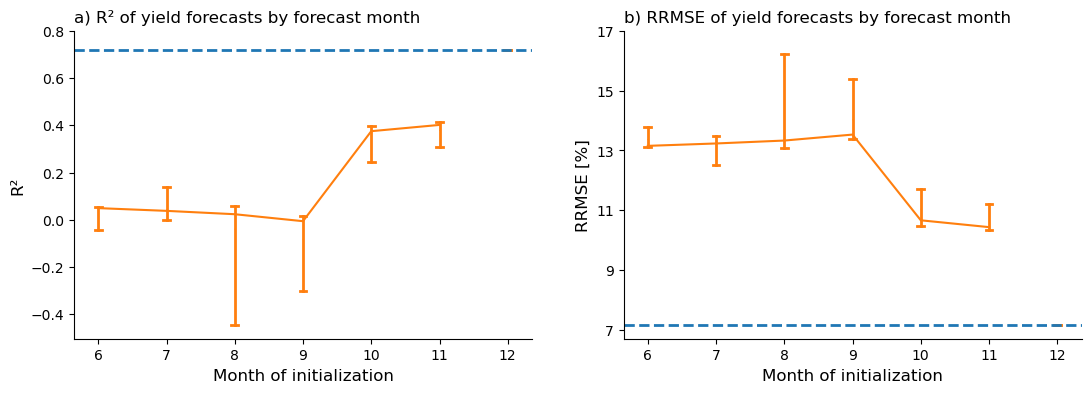

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs = axs.ravel()

data1 = results_r2.loc[(results_r2["model"] != "MME")]
data1b = results_r2.loc[(results_r2["model"].isin(unique_scm))]

#sns.pointplot(data1b,  x="init_month", y="R2", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="grey", errwidth=2, ax=axs[0])
sns.pointplot(data1,  x="init_month", y="R2", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[0])

data2 = results_r2.loc[(results_r2["init_month"] != 12) & (results_r2["model"] == "MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({6:0, 7:1, 8:2, 9:3, 10:4, 11:5})
sns.lineplot(data2, x="init_month", y="R2", color="#FF7F0E", ax=axs[0])
axs[0].set_title("a) R\u00b2 of yield forecasts by forecast month", loc="left", fontsize=12)
axs[0].set_xlabel("Month of initialization", fontsize=12)
axs[0].set_yticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].axhline(0.72, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[0].spines[['right', 'top']].set_visible(False)

data1 = results_rmse.loc[(results_rmse["model"] != "MME")]
data1b = results_rmse.loc[(results_rmse["model"].isin(unique_scm))]
#sns.pointplot(data1b,  x="init_month", y="RRMSE [%]", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="grey", errwidth=2, ax=axs[1])
sns.pointplot(data1,  x="init_month", y="RRMSE [%]", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[1])
data2 = results_rmse.loc[(results_rmse["init_month"] != 12) & (results_rmse["model"] == "MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({6:0, 7:1, 8:2, 9:3, 10:4, 11:5})
sns.lineplot(data2, x="init_month", y="RRMSE [%]", color="#FF7F0E", ax=axs[1])
axs[1].set_title("b) RRMSE of yield forecasts by forecast month", loc="left", fontsize=12)
axs[1].set_xlabel("Month of initialization", fontsize=12)
axs[1].set_ylabel("RRMSE [%]", fontsize=12)
axs[1].set_yticks(list(range(7, 18, 2)))
axs[1].axhline(7.15, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[1].spines[['right', 'top']].set_visible(False)

plt.savefig("files/figures/figure6.svg");
plt.show();


### 4. Visualize forecasts by year for Figure 5

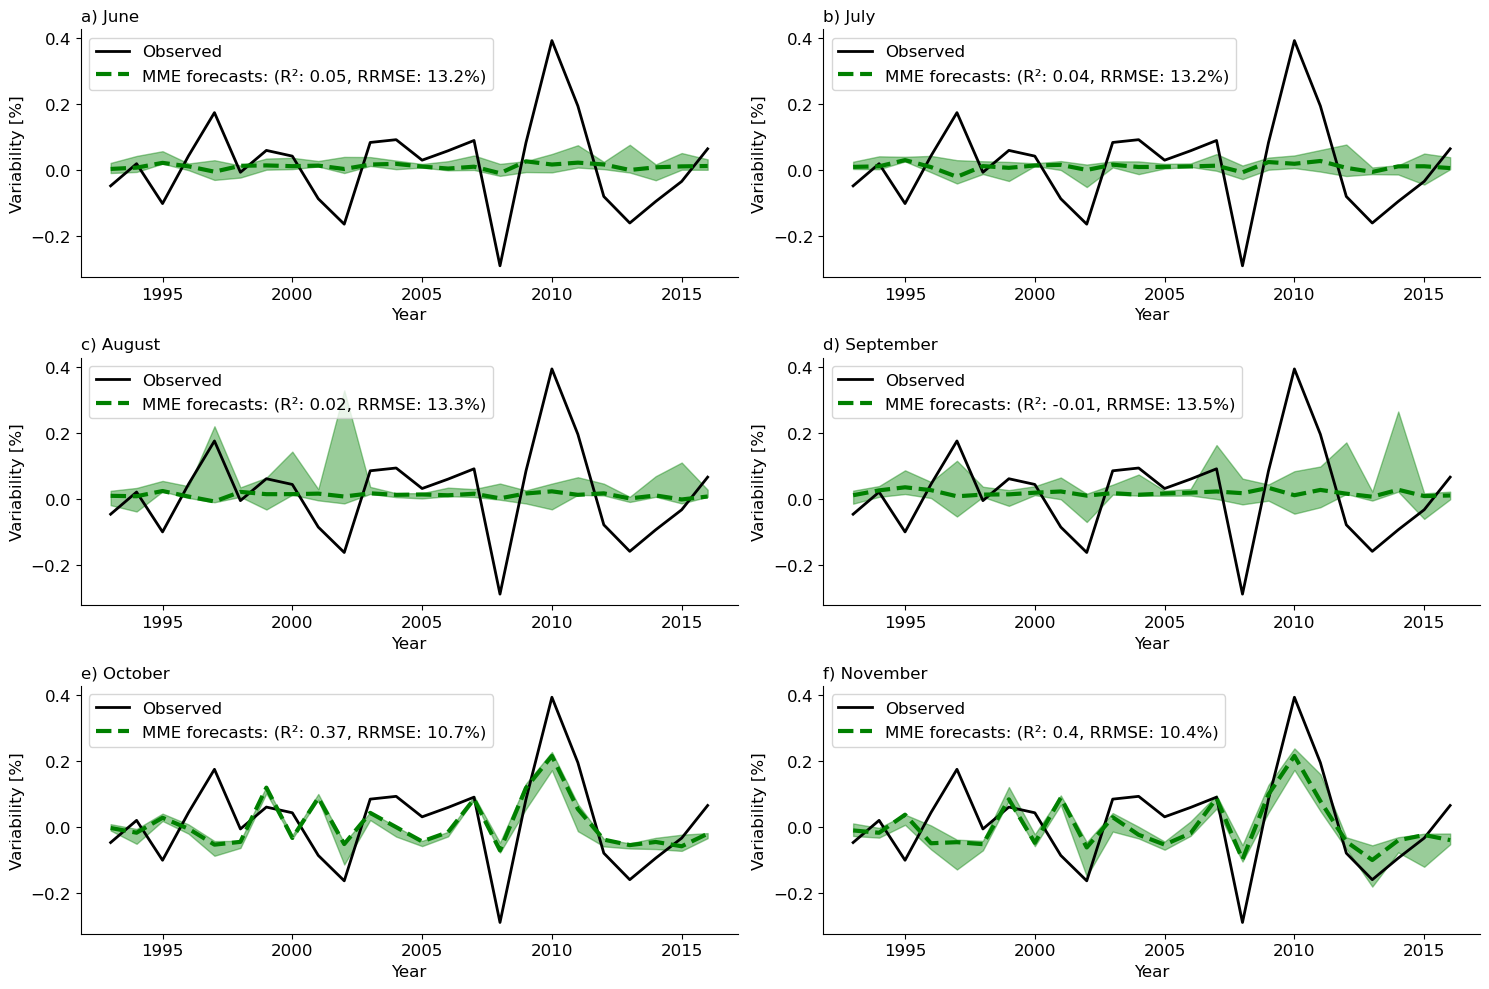

In [72]:
fig, axs = plt.subplots(3,2, figsize=(15,10))
axs = axs.ravel()

titles = dict(zip([6, 7, 8, 9, 10, 11], ["a) June", "b) July", "c) August", "d) September", "e) October", "f) November"]))
for im in list(range(6, 12)):
    plot_all = predictions.loc[:, ["year", "yield anomaly [%]", "predicted_ECCC_12"] + [c for c in predictions.columns if str(im) in c]].set_index("year")
    plot_all = plot_all.rename(columns={"predicted_ECCC_12":"estimated", "yield anomaly [%]":"observed"})
    min_values = plot_all[[c for c in plot_all.columns if str(im) in c]].min(axis=1).values
    max_values = plot_all[[c for c in plot_all.columns if str(im) in c]].max(axis=1).values
    mme_r2 = np.round(results_r2.loc[(results_r2["init_month"] == im) & (results_r2["model"]=="MME"), "R2"].values[0], 2)
    mme_rrmse = np.round(results_rmse.loc[(results_rmse["init_month"] == im) & (results_rmse["model"]=="MME"), "RRMSE [%]"].values[0], 1)
    mme_label = "MME forecasts: (R\u00b2: {}, RRMSE: {}%)".format(mme_r2, mme_rrmse)
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["observed"], linewidth=2, color="black", label="Observed", alpha=1, ax=axs[6+(im-12)])
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["predicted_MME_{}".format(im)], linewidth=3, color="green", 
                 label=mme_label, linestyle="--", ax=axs[6+(im-12)])
   
    
    axs[6+(im-12)].fill_between(plot_all.index, min_values, max_values, color="green", alpha=0.4)
    axs[6+(im-12)].set_xlabel("Year", fontsize=12)
    axs[6+(im-12)].set_ylabel("Variability [%]", fontsize=12)
    #ax.set_ylim(1.9, 3.3)
    axs[6+(im-12)].xaxis.set_tick_params(labelsize=12)
    axs[6+(im-12)].yaxis.set_tick_params(labelsize=12)
    axs[6+(im-12)].legend(fontsize=12)
    name = str(titles[im])
    axs[6+(im-12)].set_title(name, loc="left")
    axs[6+(im-12)].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig("files/figures/figure7.png")
plt.show()